# Simpel FFN

In [7]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

from data_loader import parse_data

import glob
import pandas as pd
import branca

# Import data

In [59]:
files_train = glob.glob('../data/train/*/vehicle-position-matched-online.csv')
files_test = glob.glob('../data/test/*/vehicle-position-matched-online.csv')
train = parse_data(files_train)
test = parse_data(files_test)

train = train.pivot(index='Time',columns='wayId',values='mean')
test = test.pivot(index='Time',columns='wayId',values='mean')
print("Train Shape: ",train.shape)
print("Test Shape: ",test.shape)

Train Shape:  (772, 80)
Test Shape:  (193, 80)


wayId,103524893,103524902,108233932,108233935,108233940,115678954,115678957,115678974,161632579,162089321,...,78412355,8122758,87341541,87341562,87397711,87398581,87451616,87502481,87502482,87724803
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-01 06:00:00,12.495714,7.827246,11.000000,9.563333,9.425000,4.441892,1.025000,3.262143,6.747453,6.659091,...,2.243918,2.313721,10.285833,5.357143,10.503478,6.701811,10.231731,7.322857,9.347222,5.796563
2018-10-01 06:05:00,NaN,8.515152,10.847500,0.429737,0.025000,2.554833,6.680000,8.082727,6.784225,6.375833,...,3.668333,6.028333,10.431053,10.310000,9.101786,8.348081,9.660494,11.327273,9.670769,5.431356
2018-10-01 06:10:00,10.858462,10.563962,10.233333,9.236000,8.430000,5.989167,NaN,6.403333,7.908571,9.037500,...,9.726364,4.854737,10.156286,6.642500,7.301824,6.506937,9.856973,7.446667,11.815000,8.221633
2018-10-01 06:15:00,NaN,7.312644,12.876667,11.467500,10.266667,7.054000,0.660000,8.096364,7.008462,2.826667,...,2.591692,4.918750,10.687692,5.358235,NaN,8.236250,9.560848,5.125208,8.088182,4.953455
2018-10-01 06:20:00,10.887500,6.220725,8.430000,5.667500,0.000000,3.360192,2.293333,7.037500,6.640303,5.235882,...,3.445729,5.643214,10.857391,5.028293,7.267042,8.902581,9.589159,NaN,NaN,11.443636


In [99]:
print("Train before interpolate: ",train.isnull().sum().sum())
print("Test before interpolate: ",test.isnull().sum().sum())
train = train.interpolate()
test = test.interpolate()
print("Train after interpolate: ",train.isnull().sum().sum())
print("Test after interpolate: ",test.isnull().sum().sum())
train

Train before interpolate:  12368
Test before interpolate:  3272
Train after interpolate:  4
Test after interpolate:  20


wayId,103524893,103524902,108233932,108233935,108233940,115678954,115678957,115678974,161632579,162089321,...,78412355,8122758,87341541,87341562,87397711,87398581,87451616,87502481,87502482,87724803
Time,,,,,,,,,,,,,,,,,,,,,
2018-10-01 06:00:00,12.495714,7.827246,11.000000,9.563333,9.425000,4.441892,1.025000,3.262143,6.747453,6.659091,...,2.243918,2.313721,10.285833,5.357143,10.503478,6.701811,10.231731,7.322857,9.347222,5.796563
2018-10-01 06:05:00,11.677088,8.515152,10.847500,0.429737,0.025000,2.554833,6.680000,8.082727,6.784225,6.375833,...,3.668333,6.028333,10.431053,10.310000,9.101786,8.348081,9.660494,11.327273,9.670769,5.431356
2018-10-01 06:10:00,10.858462,10.563962,10.233333,9.236000,8.430000,5.989167,3.670000,6.403333,7.908571,9.037500,...,9.726364,4.854737,10.156286,6.642500,7.301824,6.506937,9.856973,7.446667,11.815000,8.221633
2018-10-01 06:15:00,10.872981,7.312644,12.876667,11.467500,10.266667,7.054000,0.660000,8.096364,7.008462,2.826667,...,2.591692,4.918750,10.687692,5.358235,7.284433,8.236250,9.560848,5.125208,8.088182,4.953455
2018-10-01 06:20:00,10.887500,6.220725,8.430000,5.667500,0.000000,3.360192,2.293333,7.037500,6.640303,5.235882,...,3.445729,5.643214,10.857391,5.028293,7.267042,8.902581,9.589159,6.190260,8.386948,11.443636
2018-10-01 06:25:00,13.210625,8.393651,11.210000,2.360000,9.075000,3.324655,0.820000,7.144000,6.877404,5.525385,...,1.536548,2.994706,12.347000,6.935556,5.871557,4.835000,8.745563,7.255313,8.685714,11.801875
2018-10-01 06:30:00,9.773478,7.623846,8.407500,6.065000,9.157500,3.289118,2.180000,5.746000,5.955745,5.501667,...,1.473077,2.907941,9.245862,2.284286,4.476071,5.179564,9.770566,5.239667,3.974857,5.652273
2018-10-01 06:35:00,10.374762,6.725625,10.440000,0.935000,9.240000,2.697647,3.540000,6.888000,6.236712,2.020000,...,0.737842,1.145522,11.270909,8.122222,7.425294,4.626902,8.761850,5.491429,4.660000,7.231875
2018-10-01 06:40:00,11.940556,6.958522,11.516667,1.758182,4.546154,2.807907,4.900000,6.243000,5.125590,2.541765,...,2.407328,2.260408,11.360476,3.583600,6.080930,5.848249,9.190806,4.201154,3.730000,10.222692


768
80


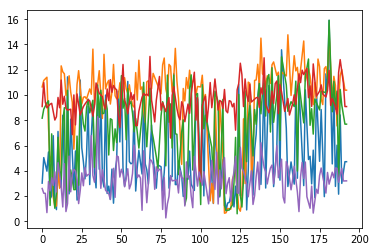

In [112]:
plt.plot(test.values[:,9:14])
print(12*(22-6)*4)
print(train.shape[1])

# Describe the model

In [118]:
#Hyperparameters
num_l1 = 25
num_ways = train.shape[1]

# define network
class Net(nn.Module):
    def __init__(self, num_hidden1, num_output):
        super(Net, self).__init__()
        
        #Dropput and Batchnorm Functions
        self.dropout = nn.Dropout2d(0.2)
        self.batch1 = nn.BatchNorm1d(num_l1)
        
        # Input layer
        #Changed to kaiming normalization
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_hidden1,12)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_hidden1), 0))
        
        # Hidden layer 1
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_output, num_hidden1)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_output), 0))
        
               
        # define activation function in constructor
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        
        x = F.linear(x, self.W_2, self.b_2)
        return F.softmax(x, dim=1)

net = Net(num_l1, num_ways)

#Adam Optimizer with L2 weight decay  
optimizer = optim.Adam(net.parameters(),lr = 1e-3, weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss()

In [120]:
#Test the forward pass with dummy data
x = np.random.normal(0, 1, (45, 12)).astype('float32')

print(net(Variable(torch.from_numpy(x))).size())

torch.Size([45, 80])


# Train and test the model

Epoch  1 : Train Loss 268.009247 , Train acc -1.679890, Valid acc -1.724030
Epoch 11 : Train Loss 267.979095 , Train acc -1.679890, Valid acc -1.724030
Epoch 21 : Train Loss 267.963989 , Train acc -1.679890, Valid acc -1.724030
Epoch 31 : Train Loss 267.953217 , Train acc -1.679890, Valid acc -1.724030
Epoch 41 : Train Loss 267.944244 , Train acc -1.679890, Valid acc -1.724030
Epoch 51 : Train Loss 267.936951 , Train acc -1.679890, Valid acc -1.724030
Epoch 61 : Train Loss 267.930573 , Train acc -1.679890, Valid acc -1.724030
Epoch 71 : Train Loss 267.925415 , Train acc -1.679890, Valid acc -1.724030
Epoch 81 : Train Loss 267.920715 , Train acc -1.679890, Valid acc -1.724030
Epoch 91 : Train Loss 267.916595 , Train acc -1.679890, Valid acc -1.724030


(Text(0.5,0,'Updates'), Text(0,0.5,'Acc'))

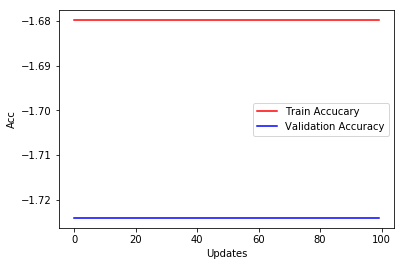

In [145]:
# setting hyperparameters and gettings epoch sizes
batch_size = 12
num_epochs = 100
num_samples_train = train.shape[0]-1
num_batches_train = num_samples_train - batch_size
num_samples_test = test.shape[0]-1
num_batches_test = num_samples_test - batch_size 

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i - size, i)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(batch_size,num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train.values[slce,:]).float().transpose(0, 1))
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(train.values[i+1,:]).long())
        batch_loss = criterion(output, target_batch)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(train.values[slce,:]).float().transpose(0, 1))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(train.values[i+1,:])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(batch_size,num_batches_test):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(test.values[slce,:]).float().transpose(0, 1))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(test.values[i+1,:])

    #train_acc_cur = accuracy_score(train_targs, train_preds)
    #valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc_cur = sum(train_targs)/len(train_targs)-sum(train_preds)/len(train_preds)
    valid_acc_cur = sum(val_targs)/len(val_targs)-sum(val_preds)/len(val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [106]:
get_slice = lambda i, size: range(i - size, i)

for i in range(12,40):
    slce = get_slice(i, 12)
    print(slce)

range(0, 12)
range(1, 13)
range(2, 14)
range(3, 15)
range(4, 16)
range(5, 17)
range(6, 18)
range(7, 19)
range(8, 20)
range(9, 21)
range(10, 22)
range(11, 23)
range(12, 24)
range(13, 25)
range(14, 26)
range(15, 27)
range(16, 28)
range(17, 29)
range(18, 30)
range(19, 31)
range(20, 32)
range(21, 33)
range(22, 34)
range(23, 35)
range(24, 36)
range(25, 37)
range(26, 38)
range(27, 39)
